In [1]:
import glob
import os

import torch
import matplotlib.pyplot as plt
import numpy as np
import yaml

from dbo.util import configure_matplotlib

configure_matplotlib()

In [2]:
def plot_average(run_results: torch.Tensor, t_points=None, n_std: int = 1, c='b', ls='-', label=None):
    if not torch.is_tensor(run_results):
        run_results = torch.as_tensor(run_results)
    assert run_results.ndim > 1
    n = run_results.shape[1]
    iterations = np.arange(n) + 1
    if t_points is None:
        t_points = iterations
    filtered_idx = torch.isfinite(run_results).all(dim=0)
    filtered_results = run_results[:, filtered_idx]
    filtered_t_points = t_points[filtered_idx]
    filtered_iterations = iterations[filtered_idx]
    r_avg = filtered_results.cumsum(-1)/filtered_iterations
    r_mean = r_avg.mean(dim=0)
    r_std = r_avg.std(dim=0)
    plt.fill_between(filtered_t_points, r_mean - n_std*r_std, r_mean + n_std*r_std, color=c, alpha=0.3)
    plt.plot(filtered_t_points, r_mean, color=c, ls=ls, label=label)

In [3]:
def load_dbo_results(exp_dir, n_reruns):
    gs = []
    kl = []
    elbo = []
    bound = []
    for r in range(n_reruns):
        gs += [torch.load(os.path.join(exp_dir, f"run-{r+1:02}", "dbo-gs_divergences.pth"))]
        kl += [torch.load(os.path.join(exp_dir, f"run-{r+1:02}", "dbo-divergences.pth"))]
        elbo += [torch.load(os.path.join(exp_dir, f"run-{r+1:02}", "dbo-elbo.pth"))]
        bound += [torch.load(os.path.join(exp_dir, f"run-{r+1:02}", "dbo-bounds.pth"))]
    gs = torch.stack(gs)
    kl = torch.stack(kl)
    elbo = torch.stack(elbo)
    bound = torch.stack(bound)
    return gs, kl, elbo, bound

## RKHS objective

In [4]:
run_dirs = glob.glob("cr-version/toy-1D/run-*")
kl_divergences = []
kl_bounds = []
for rd in run_dirs:
    kl_divergences += [torch.load(f"{rd}/dbo-divergences.pth")]
    kl_bounds += [torch.load(f"{rd}/dbo-bounds.pth")]
kl_divergences = torch.stack(kl_divergences)
kl_bounds = torch.stack(kl_bounds)

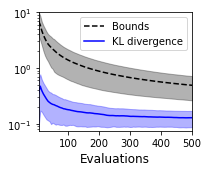

In [5]:
n_it = kl_divergences.shape[1]
n_batch = 5
t = (torch.arange(n_it) + 1)*n_batch

plt.figure(figsize=(3,2.5))
plot_average(kl_bounds, t_points=t, c='k', ls='--', label="Bounds")
plot_average(kl_divergences, t_points=t, c='b', label="KL divergence")
plt.legend()
plt.ylim(.075, 10)
plt.xlabel("Evaluations")
plt.xlim(n_batch, n_it*n_batch)
plt.yscale('log')
plt.tight_layout()
plt.savefig("toy-regret.png", dpi=300)

### Dimensionality effects

In [6]:
experiment_dirs = ["experiments/toy-2021-02-19-105524/",
                   "experiments/toy-2021-02-19-105618/",
                   "experiments/toy-2021-02-19-130124"]
n_runs = 5
n_exp = len(experiment_dirs)
dim_kl_divergences = np.zeros((n_runs, n_exp+1))
n_dims = np.zeros(n_exp+1)
for i, ed in enumerate(experiment_dirs):
    config = yaml.load(open(os.path.join(ed, "toy-args.yaml")), Loader=yaml.Loader)
    n_dims[i] = config.dimensionality
    for r in range(n_runs):
        dim_kl_divergences[r, i] = torch.load(os.path.join(ed, f"run-{r+1:02}/dbo-divergences.pth"))[-1].cpu().item()

dim_kl_divergences[:, -1] = kl_divergences[:n_runs, -1]
n_dims[-1] = 1

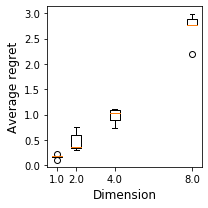

In [7]:
plt.figure(figsize=(3,3))
plt.boxplot(dim_kl_divergences, positions=n_dims)
plt.xlabel("Dimension")
plt.ylabel("Average regret")
plt.tight_layout()
plt.savefig("toy-dimensionality.png", dpi=300)

## Lumpy 2D

In [8]:
dbo_lumpy_exp_dir = "experiments/toy-2021-02-21-042935"
config = yaml.load(open(os.path.join(dbo_lumpy_exp_dir, "toy-args.yaml")), Loader=yaml.Loader)
assert config.objective == 'MixtureObjective'
n_runs = config.n_repeats
dbo_lumpy_gs, dbo_lumpy_kl, dbo_lumpy_elbo, dbo_lumpy_bound = load_dbo_results(dbo_lumpy_exp_dir, n_runs)

In [9]:
n_vbmc_runs = 5
vbmc_lumpy_gs = []
vbmc_lumpy_kl = []
vbmc_lumpy_elbo = []
vbmc_lumpy_evals = []
vbmc_dir = "experiments/uai2021_vbmc_experiments_lumpy"
for r in range(n_vbmc_runs):
    vbmc_lumpy_gs += [np.loadtxt(f"{vbmc_dir}/vbmc-lumpy-run-{r+1:02}-gsKL.csv", delimiter=',')]
    vbmc_lumpy_kl += [np.loadtxt(f"{vbmc_dir}/vbmc-lumpy-run-{r+1:02}-kl.csv", delimiter=',')]
    vbmc_lumpy_elbo += [np.loadtxt(f"{vbmc_dir}/vbmc-lumpy-run-{r+1:02}-elbo.csv", delimiter=',')]
    vbmc_lumpy_evals += [np.loadtxt(f"{vbmc_dir}/vbmc-lumpy-run-{r+1:02}-f_count.csv", delimiter=',')]
vbmc_lumpy_gs = np.stack(vbmc_lumpy_gs)
vbmc_lumpy_kl = np.stack(vbmc_lumpy_kl)
vbmc_lumpy_elbo = np.stack(vbmc_lumpy_elbo)
vbmc_lumpy_evals = np.stack(vbmc_lumpy_evals)

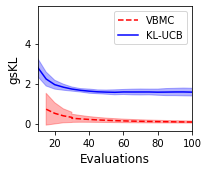

In [10]:
n_it = config.n_iterations
t = np.arange(n_it) + 1
start_t = 1
n_batch = config.n_samples_per_iteration

plt.figure(figsize=(3,2.5))
plot_average(vbmc_lumpy_gs[:, start_t:], t_points=vbmc_lumpy_evals[0, start_t:], c='r', label='VBMC', ls='--')
plot_average(dbo_lumpy_gs, t_points=t*n_batch, c='b', label='KL-UCB')
plt.ylabel("gsKL")
plt.legend()
plt.xlabel("Evaluations")
plt.xlim(10, 100)
plt.tight_layout()
plt.savefig("lumpy-gsKL.png", dpi=300)

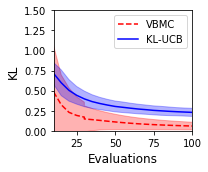

In [11]:
start_t = 0
plt.figure(figsize=(3,2.5))
plot_average(vbmc_lumpy_kl[:, start_t:], t_points=vbmc_lumpy_evals[0, start_t:], c='r', label='VBMC', ls='--')
plot_average(dbo_lumpy_kl[:, start_t:], t_points=t[start_t:]*n_batch, c='b', label='KL-UCB')
plt.ylabel("KL")
plt.ylim(0, 1.5)
plt.legend()
plt.xlabel("Evaluations")
plt.xlim(10, 100)
plt.tight_layout()
plt.savefig("lumpy-kl.png", dpi=300)

## Circular likelihood

In [12]:
n_runs = 5
vbmc_circle_gs = []
vbmc_circle_elbo = []
vbmc_circle_evals = []
vbmc_dir = "experiments/uai2021_vbmc_experiments_circle"
for r in range(n_runs):
    vbmc_circle_gs += [np.loadtxt(f"{vbmc_dir}/vbmc-circle-run-{r+1:02}-sKL_true.csv", delimiter=',')]
    vbmc_circle_elbo += [np.loadtxt(f"{vbmc_dir}/vbmc-circle-run-{r+1:02}-elbo.csv", delimiter=',')]
    vbmc_circle_evals += [np.loadtxt(f"{vbmc_dir}/vbmc-circle-run-{r+1:02}-f_count.csv", delimiter=',')]
vbmc_circle_gs = np.stack(vbmc_circle_gs)
vbmc_circle_elbo = np.stack(vbmc_circle_elbo)
vbmc_circle_evals = np.stack(vbmc_circle_evals)

In [13]:
dbo_circle_exp_dir = "experiments/toy-2021-02-21-000112"
config = yaml.load(open(os.path.join(dbo_circle_exp_dir, "toy-args.yaml")), Loader=yaml.Loader)
assert config.objective == 'CircularObjective'

dbo_circle_gs, dbo_circle_kl, dbo_circle_elbo, dbo_circle_bound = load_dbo_results(dbo_circle_exp_dir, n_runs)

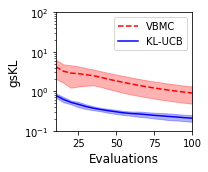

In [14]:
n_it = 20
t = np.arange(n_it) + 1
start_t = 0
n_batch = 5

plt.figure(figsize=(3,2.5))
plot_average(vbmc_circle_gs[:, start_t:], t_points=vbmc_circle_evals[0, start_t:], c='r', label='VBMC', ls='--')
plot_average(dbo_circle_gs[:, start_t:], t_points=t[start_t:]*n_batch, c='b', label='KL-UCB')
plt.ylabel("gsKL")
plt.ylim(0.1, 100)
plt.yscale('log')
plt.legend()
plt.xlabel("Evaluations")
plt.xlim(10, 100)
plt.tight_layout()
plt.savefig("circular-gsKL.png", dpi=300)

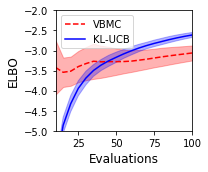

In [15]:
plt.figure(figsize=(3,2.5))
plot_average(vbmc_circle_elbo[:, start_t:], t_points=vbmc_circle_evals[0, start_t:], c='r', label='VBMC', ls='--')
plot_average(dbo_circle_elbo[:, start_t:], t_points=t[start_t:]*n_batch, c='b', label='KL-UCB')
plt.ylabel("ELBO")
plt.ylim(-5, -2)
plt.legend()
plt.xlabel("Evaluations")
plt.xlim(10, 100)
plt.tight_layout()
plt.savefig("circular-elbo.png", dpi=300)

# Likelihood-free inference

In [16]:
from dbo.util import load_object

abc_res = load_object("experiments/ABC-result-CartPole-Gaussian-prior.pkl")

In [17]:
from scipy.stats import gaussian_kde
from dbo.util import make_grid
configure_matplotlib(small_size=12, medium_size=14, bigger_size=16)
kde = gaussian_kde(abc_res.samples_array.T)

In [18]:
grid = make_grid(-3.,3.,0.03)

pdf = kde(grid.T)

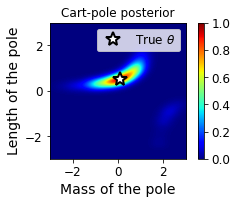

In [19]:
v_min = 0
v_max = 1.
nx = int(grid.shape[0]**0.5)
extent = [-3., 3., -3., 3.]

plt.figure(figsize=(4,3))
plt.imshow(pdf.reshape(nx, nx).T, origin='lower', interpolation='bilinear',
           extent=extent, cmap=plt.cm.jet, vmin=v_min, vmax=v_max)
plt.plot(0.1, 0.5, "w*", label=r"True $\theta$", ms=15, mec='k', mew=2)
plt.legend()
plt.xlabel("Mass of the pole")
plt.ylabel("Length of the pole")
plt.colorbar()
plt.axis(extent)
plt.title("Cart-pole posterior")
plt.tight_layout()
plt.savefig("cartpole-posterior.png")

In [20]:
dbo_final_samples = torch.load("experiments/lfi-2021-02-21-074832/run-03/lfi-final_samples.pth")

In [21]:
dbo_kde = gaussian_kde(dbo_final_samples.T)
dbo_pdf = dbo_kde(grid.T)

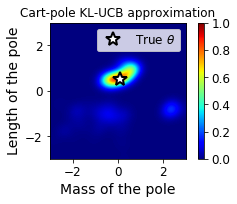

In [22]:
plt.figure(figsize=(4,3))
plt.imshow(dbo_pdf.reshape(nx, nx).T, origin='lower', interpolation='bilinear',
           extent=extent, cmap=plt.cm.jet, vmin=v_min, vmax=v_max)
plt.plot(0.1, 0.5, "w*", label=r"True $\theta$", ms=15, mec='k', mew=2)
plt.legend()
plt.axis(extent)
plt.xlabel("Mass of the pole")
plt.ylabel("Length of the pole")
plt.colorbar()
plt.axis(extent)
plt.title("Cart-pole KL-UCB approximation")
plt.tight_layout()
plt.savefig("cartpole-dbo-approximation.png")

In [23]:
bolfi_dirs = glob.glob("experiments/bolfi-2021-02-21-075*")

bolfi_final_samples = torch.load(os.path.join(bolfi_dirs[0], "bolfi-final_samples.pth"))

In [24]:
bolfi_kde = gaussian_kde(bolfi_final_samples.T)
bolfi_pdf = bolfi_kde(grid.T)

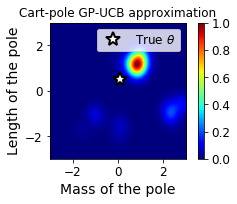

In [25]:
plt.figure(figsize=(4,3))
plt.imshow(bolfi_pdf.reshape(nx, nx).T, origin='lower', interpolation='bilinear',
           extent=extent, cmap=plt.cm.jet, vmin=v_min, vmax=v_max)
plt.plot(0.1, 0.5, "w*", label=r"True $\theta$", ms=15, mec='k', mew=2)
plt.legend()
plt.axis(extent)
plt.xlabel("Mass of the pole")
plt.ylabel("Length of the pole")
plt.colorbar()
plt.title("Cart-pole GP-UCB approximation")
plt.tight_layout()
plt.savefig("cartpole-bolfi-approximation.png")

### LFI Reruns

In [26]:
bolfi_dirs = glob.glob("experiments/bolfi-2021-02-21-075*")

n_runs = len(bolfi_dirs)
n_it = 200
bolfi_kl = np.zeros((n_runs, n_it))

for i, ed in enumerate(bolfi_dirs):
    bolfi_kl[i] = torch.load(os.path.join(ed, "bolfi-divergences.pth"))

In [27]:
lfi_dir = "experiments/lfi-2021-02-21-074832"
lfi_kl = []
config = yaml.load(open(os.path.join(lfi_dir, "lfi-args.yaml")), Loader=yaml.Loader)
n_runs = config.n_repeats
n_it = config.n_iterations
n_batch = config.n_samples_per_iteration
for r in range(n_runs):
    lfi_kl += [torch.load(os.path.join(lfi_dir, f"run-{r+1:02}", "lfi-divergences.pth"))]
lfi_kl = torch.stack(lfi_kl)

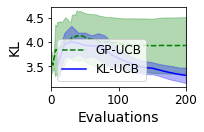

In [28]:
plt.figure(figsize=(3,2))
t = np.arange(n_it) + 1
plot_average(bolfi_kl, c='g', label='GP-UCB', ls='--')
plot_average(lfi_kl, t_points=t*n_batch, c='b', label='KL-UCB')
plt.legend()
plt.xlim(0,n_it*n_batch)
plt.xlabel("Evaluations")
plt.ylabel("KL")
plt.tight_layout()
plt.savefig("lfi-regret.png", dpi=300)